In [1]:
# Oedometer-test
from math import pi,sin, sqrt
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import meshio

In [2]:
plt.rcParams['font.serif'] = ['Helvetica'] + plt.rcParams['font.serif']
plt.rcParams['lines.linewidth'] = 4
font1 = {'size': 24, 'color':  'black'}

## Analytic Solution to the Mohr-Coulomb Simple shear

```BASH
  ^ y
  |
1 |____   vx(y) = vx*y
  |    | -->
0 |____|_->____> x
       1
```



- $v_{x}(y) = v_{x}y$ in $\{(x,y)| (x,y) \in [0,1] \times [0,1]\}.$
- $v_{y} = 0$ and $0 \le y \le 1$
- $u(y,t) = (v_{x}yt, 0)$
$$
\varepsilon_{xy} = \frac{1}{2}\frac{\partial (v_{x}yt)}{\partial y} = \frac{1}{2} v_{x} t.
$$

$$
\sigma_{xy} = 2\mu\varepsilon_{xy} = \mu v_{x} t,
$$
where $\mu$ is a shear modulus.

$$
\Delta\boldsymbol{\varepsilon} = 
\begin{pmatrix}
0 & \frac{1}{2} v_{x} \Delta t \\
\frac{1}{2} v_{x} \Delta t & 0
\end{pmatrix}

\Rightarrow

\Delta \mathbf{e} = 
\begin{pmatrix}
-\frac{1}{2} v_{x} \Delta t & 0 \\
0 & \frac{1}{2} v_{x} \Delta t
\end{pmatrix}
$$

$$
\Delta\boldsymbol{\sigma} = 
\begin{pmatrix}
0 & \mu v_{x} \Delta t \\
\mu v_{x} \Delta t & 0
\end{pmatrix}

\Rightarrow

\Delta\mathbf{S} = 
\begin{pmatrix}
-\mu v_{x} \Delta t & 0 \\
0 & \mu v_{x} \Delta t
\end{pmatrix}
$$
Here $S_{1} < S_{2}$ and $e_{1} < e_{2}$ and the tension positive convention is followed.

The principal directions are the columns of the following matrix:
$$
\mathbf{V} = 
\begin{pmatrix}
\cos(\pi/4) & \sin(\pi/4) \\
-\sin(\pi/4) & \cos(\pi/4)
\end{pmatrix}
=
\begin{pmatrix}
1/\sqrt{2} & 1/\sqrt{2} \\
-1/\sqrt{2} & 1/\sqrt{2}
\end{pmatrix}
$$

$$
\begin{split}
\Delta\mathbf{S} &= \mathbf{V}^{T}\Delta\boldsymbol{\sigma}\mathbf{V} \\
\Delta\boldsymbol{\sigma} &= \mathbf{V} \Delta\mathbf{S} \mathbf{V}^{T}.
\end{split}
$$

$$
\begin{split}
f_{s}(S^{n+1}_{1}, S^{n+1}_{2}) &= (S^{n}_{1} + 2\mu\Delta\varepsilon_{1}^{e}) - N_{\phi}(S^{n}_{2} + 2\mu\Delta\varepsilon_{2}^{e}) + 2c\sqrt{N_{\phi}}, \\
g_{s}(S^{n+1}_{1}, S^{n+1}_{2}) &= S^{n+1}_{1} - N_{\psi}S^{n+1}_{2},\\
\end{split}
$$

$$ 
\begin{split}
\Delta\varepsilon_{1}^{e} &= \Delta\varepsilon_{1} - \Delta\beta \frac{\partial g}{\partial S_{1}} = \Delta\varepsilon_{1} - \Delta\beta,\\
\Delta\varepsilon_{2}^{e} &= \Delta\varepsilon_{2} - \Delta\beta \frac{\partial g}{\partial S_{2}} = \Delta\varepsilon_{2} + N_{\psi}\Delta\beta.
\end{split}
$$

From $f_{s}(S^{n+1}_{1}, S^{n+1}_{2}) = 0 $,

$$
(S^{n}_{1} + 2\mu(\Delta\varepsilon_{1} - \Delta\beta)) - N_{\phi}(S^{n}_{2} + 2\mu (\Delta\varepsilon_{3} + N_{\psi}\Delta\beta)) + 2c\sqrt{N_{\phi}} = 0.
$$

$$
(S^{n+1,el}_{1} - 2\mu \Delta\beta) - N_{\phi}(S^{n+1,el}_{2} + 2 \mu N_{\psi} \Delta\beta) + 2c\sqrt{N_{\phi}} = 0.
$$

$$
\Delta\beta = \frac{f_{s}(S^{n+1,el}_{1},S^{n+1,el}_{2})}{2\mu(1+N_{\phi}N_{\psi})}.
$$

When $\psi=0$ and $N_{\psi}=1$, the plastic corrections for $S_{1}$ and $S_{2}$ are identical in magnitude and opposite in sign. Together with the shape of the elastic stress tensor, this property allows the plastic Cauchy stress tensor have the same shape: zero-diagonals and symmetric. Also, $\sigma_{xy}^{n+1}$ is always equal to either $S^{n+1,el}_{2}$ or $S^{n+1,pl}_{2}$.

Summarized below is the algorithm for the analytic solution for the simple shear case:
1. $\sigma^{n+1,el}_{xy} = \sigma^{n,el}_{xy} + \mu v_{x} \Delta t$.
1. $S^{n+1,el}_{1} = -\sigma^{n+1,el}_{xy}$ and $S^{n+1,el}_{2} = \sigma^{n+1,el}_{xy}$.
2. If $f_{s}(\mathbf{S}^{n+1,el}) > 0$, $\sigma^{n+1}_{xy} = \sigma^{n+1,el}_{xy}$; continue
3. If $f_{s}(\mathbf{S}^{n+1,el}) <= 0$, 
    1. $\Delta\beta = \frac{f_{s}(S^{n+1,el}_{1},S^{n+1,el}_{2})}{2\mu(1+N_{\phi}N_{\psi})}$.
    2. $\bar{S}^{n+1}_{1} = S^{n+1,el}_{1} - 2\mu \Delta\beta$
    3. $\bar{S}^{n+1}_{2} = S^{n+1,el}_{2} + 2\mu \Delta\beta$ because $N_{\psi} = 1$.
    4. $\bar{\sigma}^{n+1}_{xy} = \bar{S}^{n+1}_{2}$
    5. $\sigma^{n+1}_{xy} = (\sigma^{n+1,el}_{xy} + \frac{\Delta t}{\eta} \bar{\sigma}^{n+1}_{xy} ) / (1 + \frac{\Delta t}{\eta})$

In [3]:
def analytical(phi, psi, cohesion, viscosity, dt, total_time = 650.0):
    vx = 1e-5

    mu = 200e6
    coh = cohesion
    phi = phi * np.pi/180.0
    if psi != 0.0:
        print('psi = {0:.1g} but should be zero!'.format(psi))
        return
    psi = psi * np.pi/180.0
    sf = np.sin(phi)
    sp = np.sin(psi)
    nphi = (1.0+sf)/(1.0-sf)
    npsi = (1.0+sp)/(1.0-sp)

    nstep = int(total_time/dt)+1
    displacement = vx * dt * np.array(range(nstep), dtype=float)
    exy =     np.zeros(nstep, dtype=float)
    Sxy =     np.zeros(nstep, dtype=float)
    Sxy_bar = np.zeros(nstep, dtype=float)

    dt_scaled = dt/viscosity
    print(nstep, dt_scaled)

    for i in range(1, int(total_time/dt)+1):
        dexy = 0.5 * vx * dt
        dSxy_el = 2.0*mu * dexy
        exy[i] = exy[i-1] + dexy
        Sxy_el = Sxy[i-1] + dSxy_el

        S1_el = -Sxy_el
        S3_el = Sxy_el
        fs = S1_el - S3_el*nphi + 2.0*coh*sqrt(nphi)

        if fs > 0:
            Sxy[i] = Sxy_el
        elif fs <= 0:
            dbeta      = fs/(2.0*mu*(1.0+nphi*npsi))
            S1_bar = S1_el - 2.0 * mu * dbeta
            S3_bar = S3_el + 2.0 * mu * dbeta * npsi
            if S1_bar != -S3_bar:
                print('step = ', i, ' S1_bar != -S3_bar')
                return
            Sxy_bar[i] = S3_bar
            Sxy[i]     = ( Sxy_el + dt_scaled * Sxy_bar[i] ) / (1.0 + dt_scaled)
            
    return displacement, Sxy, Sxy_bar

In [4]:
phi = 30.0
psi = 0.0
cohesion = 1.0e6
dt = 1.0e0
start_time = 0.0
end_time = 3000.0

viscosity_list = np.array( [dt/1.0e+1, dt/1.0e-2, dt/2.0e-3, dt/1.0e-3, dt/5.0e-4, dt/1.0e-6] ) 
adisp_list = []
aSxy_list = []
aSxy_bar_list = []

print(viscosity_list)
for viscosity in viscosity_list:
    displacement, Sxy, Sxy_bar = analytical(phi, psi, cohesion, viscosity, dt, end_time)
    adisp_list.append(displacement)
    aSxy_list.append(Sxy)
    aSxy_bar_list.append(Sxy_bar)


[1.e-01 1.e+02 5.e+02 1.e+03 2.e+03 1.e+06]
3001 10.0
3001 0.01
3001 0.002
3001 0.001
3001 0.0005
3001 1e-06


In [5]:
laghos_data1 = np.loadtxt("laghost_solution_1.txt")
laghos_data2 = np.loadtxt("laghost_solution_2.txt")
laghos_data3 = np.loadtxt("laghost_solution_3.txt")
laghos_data4 = np.loadtxt("laghost_solution_4.txt")
laghos_data5 = np.loadtxt("laghost_solution_5.txt")
laghos_data6 = np.loadtxt("laghost_solution_6.txt")

0 0 3000
1 0 3000
2 0 3000
3 0 3000
4 0 3000
5 0 3000


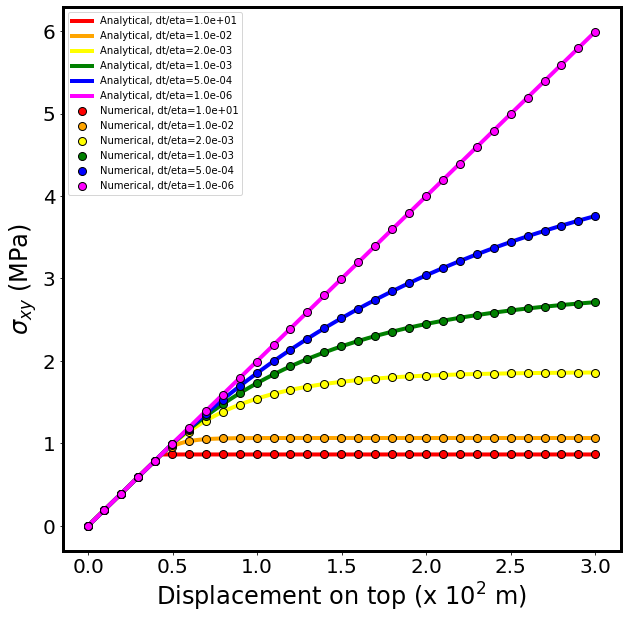

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
# ax.tick_params(direction='in', length=6, width=2, colors='k')
plt.setp(ax.spines.values(), linewidth=3)

# plt.setp(ax.spines.values(), linewidth=3)

# Analytic solution
for i, visc in enumerate(viscosity_list):
    print(i, int(start_time/dt), int(end_time/dt))
    if(i == 0):
        ax.plot(adisp_list[i][int(start_time/dt):int(end_time/dt)]*100, aSxy_list[i][int(start_time/dt):int(end_time/dt)] * 1e-6, linestyle='-', color='red', label='Analytical, dt/eta={0:.1e}'.format(dt/visc))
    elif(i == 1):
        ax.plot(adisp_list[i][int(start_time/dt):int(end_time/dt)]*100, aSxy_list[i][int(start_time/dt):int(end_time/dt)] * 1e-6, linestyle='-', color='orange', label='Analytical, dt/eta={0:.1e}'.format(dt/visc))
    elif(i == 2):
        ax.plot(adisp_list[i][int(start_time/dt):int(end_time/dt)]*100, aSxy_list[i][int(start_time/dt):int(end_time/dt)] * 1e-6, linestyle='-', color='yellow', label='Analytical, dt/eta={0:.1e}'.format(dt/visc))
    elif(i == 3):
        ax.plot(adisp_list[i][int(start_time/dt):int(end_time/dt)]*100, aSxy_list[i][int(start_time/dt):int(end_time/dt)] * 1e-6, linestyle='-', color='green', label='Analytical, dt/eta={0:.1e}'.format(dt/visc))
    elif(i == 4):
        ax.plot(adisp_list[i][int(start_time/dt):int(end_time/dt)]*100, aSxy_list[i][int(start_time/dt):int(end_time/dt)] * 1e-6, linestyle='-', color='blue', label='Analytical, dt/eta={0:.1e}'.format(dt/visc))
    elif(i == 5):
        ax.plot(adisp_list[i][int(start_time/dt):int(end_time/dt)]*100, aSxy_list[i][int(start_time/dt):int(end_time/dt)] * 1e-6, linestyle='-', color='magenta', label='Analytical, dt/eta={0:.1e}'.format(dt/visc))


# Numerical solution
ax.plot(-1*laghos_data1[:,0]*100, -1*laghos_data1[:,1] * 1e-6, 'o', markerfacecolor='r', color='k', markersize=8, label='Numerical, dt/eta=1.0e+01')
ax.plot(-1*laghos_data2[:,0]*100, -1*laghos_data2[:,1] * 1e-6, 'o', markerfacecolor='orange',color='k', markersize=8, label='Numerical, dt/eta=1.0e-02')
ax.plot(-1*laghos_data3[:,0]*100, -1*laghos_data3[:,1] * 1e-6, 'o', markerfacecolor='yellow',color='k', markersize=8, label='Numerical, dt/eta=2.0e-03')
ax.plot(-1*laghos_data4[:,0]*100, -1*laghos_data4[:,1] * 1e-6, 'o', markerfacecolor='green',color='k', markersize=8, label='Numerical, dt/eta=1.0e-03')
ax.plot(-1*laghos_data5[:,0]*100, -1*laghos_data5[:,1] * 1e-6, 'o', markerfacecolor='blue',color='k', markersize=8, label='Numerical, dt/eta=5.0e-04')
ax.plot(-1*laghos_data6[:,0]*100, -1*laghos_data6[:,1] * 1e-6, 'o', markerfacecolor='magenta',color='k', markersize=8, label='Numerical, dt/eta=1.0e-06')

ax.set_xlabel("Displacement on top (x $10^{2}$ m)", fontdict=font1)
ax.set_ylabel("$\sigma_{xy}$ (MPa)", fontdict=font1)
ax.legend()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.savefig('./simple_shear_viscoplasticity.jpg', dpi=150)
# plt.show()

In [7]:
def compute_relative_error(y, analytic, laghos_y, laghos):
    return np.linalg.norm(analytic[0:-1] - np.interp(y[0:-1], laghos_y, laghos))/np.linalg.norm(analytic[0:-1])

error_1 = compute_relative_error(adisp_list[0][int(start_time/dt):int(end_time/dt)]*100, aSxy_list[0][int(start_time/dt):int(end_time/dt)]*1e-6, -1*laghos_data1[:,0]*100, -1*laghos_data1[:,1] * 1e-6 )
print("Rel. error for dt/eta = 10: {0:.3e}".format(error_1))

error_2 = compute_relative_error(adisp_list[1][int(start_time/dt):int(end_time/dt)]*100, aSxy_list[1][int(start_time/dt):int(end_time/dt)]*1e-6, -1*laghos_data2[:,0]*100, -1*laghos_data2[:,1] * 1e-6 )
print("Rel. error for dt/eta = 1e-2: {0:.3e}".format(error_2))

error_3 = compute_relative_error(adisp_list[2][int(start_time/dt):int(end_time/dt)]*100, aSxy_list[2][int(start_time/dt):int(end_time/dt)]*1e-6, -1*laghos_data3[:,0]*100, -1*laghos_data3[:,1] * 1e-6 )
print("Rel. error for dt/eta = 2e-3: {0:.3e}".format(error_3))

error_4 = compute_relative_error(adisp_list[3][int(start_time/dt):int(end_time/dt)]*100, aSxy_list[3][int(start_time/dt):int(end_time/dt)]*1e-6, -1*laghos_data4[:,0]*100, -1*laghos_data4[:,1] * 1e-6 )
print("Rel. error for dt/eta = 1e-3: {0:.3e}".format(error_4))

error_5 = compute_relative_error(adisp_list[4][int(start_time/dt):int(end_time/dt)]*100, aSxy_list[4][int(start_time/dt):int(end_time/dt)]*1e-6, -1*laghos_data5[:,0]*100, -1*laghos_data5[:,1] * 1e-6 )
print("Rel. error for dt/eta = 5e-4: {0:.3e}".format(error_5))

error_6 = compute_relative_error(adisp_list[5][int(start_time/dt):int(end_time/dt)]*100, aSxy_list[5][int(start_time/dt):int(end_time/dt)]*1e-6, -1*laghos_data6[:,0]*100, -1*laghos_data6[:,1] * 1e-6 )
print("Rel. error for dt/eta = 1e-6: {0:.3e}".format(error_6))

Rel. error for dt/eta = 10: 6.076e-03
Rel. error for dt/eta = 1e-2: 2.350e-03
Rel. error for dt/eta = 2e-3: 8.188e-04
Rel. error for dt/eta = 1e-3: 5.447e-04
Rel. error for dt/eta = 5e-4: 4.168e-04
Rel. error for dt/eta = 1e-6: 2.920e-04
